# Process Data

In [5]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import nexusformat.nexus as nx
import pickle
import json
from tqdm import tqdm
import datetime


from fault_management_uds.data.data_utilities import delete_group, create_group, print_tree
from fault_management_uds.data.prepare import prepare_sensor_series
from fault_management_uds.data.load_save_data import load_dataframe, save_dataframe, overwrite_dataset, save_filtered_data
from fault_management_uds.data.load_save_data import save_metadata, load_metadata, import_metadata


from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR

### Understanding the data

check the bellinge article, 

- Figure 4: how the sewage system works and what the sensors measure
- Table 1: the sensors
- Figure 7: the sewer data, when available, when outliers, when nan
- Figure 13: The available data



### Create the HDF5 dataset

In [6]:
data_file_path = PROCESSED_DATA_DIR / 'Bellinge.h5'

In [3]:
# Create sample data
data = np.random.random(size=(10, 10))

mode = 'w' if not os.path.exists(data_file_path) else 'a'

# Open or create an HDF5 file in append mode
with h5py.File(data_file_path, mode) as hdf:
    # Check if 'dummy' dataset exists and delete it if it does
    if 'dummy' in hdf:
        del hdf['dummy']
    # Create a new dataset
    hdf.create_dataset('dummy', data=data)

print("HDF5 file created or modified and dataset added.")

HDF5 file created or modified and dataset added.


In [4]:
print_tree(data_file_path)

root
├── dummy
└── processed
    ├── combined_data
    │   ├── cleaned
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   ├── interpolated
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   ├── is_error
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   ├── no_data
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   └── raw
    │       ├── columns
    │       ├── data
    │       └── timestamps
    └── single_series
        ├── 5425
        │   ├── columns
        │   ├── data
        │   └── timestamps
        ├── 5427
        │   ├── columns
        │   ├── data
        │   └── timestamps
        ├── G71F04R_Level1
        │   ├── columns
        │   ├── data
        │   └── timestamps
        ├── G71F04R_Level2
        │   ├── columns
        │   ├── data
        │   └── timestamps
        ├── G71F05R_LevelBasin
        │   ├── columns
        │   ├── data
        │   └

NXroot('Bellinge')

### Metadata

In [5]:
sensor_data_path = EXTERNAL_DATA_DIR / 'Bellinge' / 'sensor-data'
raw_data_path = sensor_data_path / '2_raw_data'
scripts_path = EXTERNAL_DATA_DIR / 'Bellinge' / 'scripts'

In [6]:

metadata, manual_remove = import_metadata(scripts_path)

print(metadata.columns)
print(metadata.shape)
metadata.head()

Index(['IdMeasurement', 'Area', 'Source', 'Version', 'Type', 'Folderpath',
       'Filename', 'TagSRO', 'Navn', 'StartTime', 'EndTime', 'Conversion',
       'comment', 'unit', 'obvious_min', 'obvious_max', 'zeropoint',
       'window_frozen', 'outlier_threshold', 'outlier_width'],
      dtype='object')
(36, 20)


,IdMeasurement,Area,Source,Version,Type,Folderpath,Filename,TagSRO,Navn,StartTime,EndTime,Conversion,comment,unit,obvious_min,obvious_max,zeropoint,window_frozen,outlier_threshold,outlier_width
31,G71F04R_Level1,Bellinge,System2000,p1,Level,./2_raw_data/,data-pG71F04R-D1-W1-BL3_M2-PV-SMO.txt,G71F04R-D1-W1-BL3_M2-PV-SMO,Niv. Indløb 1,2010-08-01,2020-01-06,100.000000,cm -> m,cm,0.001,1.5,17.09,20,0.2,1
4,G71F04R_Level1,Bellinge,System2000,p2,Level,./2_raw_data/,data-pG71F04R-D1-W1-BL3_M2-PV-SMO_red.txt,G71F04R-D1-W1-BL3_M2-PV-SMO,Niv. Indløb 1,2020-01-06,2020-10-12,68.965517,cm -> m + scaling factor wrong initially (2.9/2),cm,0.001,1.5,17.09,20,0.2,1
2,G71F04R_Level1,Bellinge,iFix,p3,Level,./2_raw_data/,SVTP03.G71F04R-D1-W1-BL3!M5-PV-SMO.F_CV_red.rpt,SVTP03.G71F04R-D1-W1-BL3!M5-PV-SMO.F_CV,Niv. Indløb 1,2020-10-12,2020-11-19,0.689655,scaling factor wrong initially,cm,0.001,1.5,17.09,20,0.2,1
0,G71F04R_Level1,Bellinge,iFix,p4,Level,./2_raw_data/,SVTP03.G71F04R-D1-W1-BL3!M5-PV-SMO.F_CV.rpt,SVTP03.G71F04R-D1-W1-BL3!M5-PV-SMO.F_CV,Niv. Indløb 1,2020-11-19,2021-08-19,1.000000,NaN,m,0.001,1.5,17.09,20,0.2,1
32,G71F04R_Level2,Bellinge,System2000,p1,Level,./2_raw_data/,data-pG71F04R-D1-W1-BL4_M2-PV-SMO.txt,G71F04R-D1-W1-BL4_M2-PV-SMO,Niv. Indløb 2,2010-08-01,2020-01-06,100.000000,cm -> m,cm,0.001,1.5,17.05,20,0.2,1


In [7]:
metadata[metadata['IdMeasurement']=='G71F68Yp1']

,IdMeasurement,Area,Source,Version,Type,Folderpath,Filename,TagSRO,Navn,StartTime,EndTime,Conversion,comment,unit,obvious_min,obvious_max,zeropoint,window_frozen,outlier_threshold,outlier_width
27,G71F68Yp1,Bellinge,System2000,p1,Discharge,./2_raw_data/,data-pG71F68Y-D1-W2-BF1_M5-PV-SMO.txt,G71F68Y-D1-W2-BF1_M5-PV-SMO,Flowmåler,2010-08-01,2020-10-12,3600.0,m3/h -> m3/s,m3/h,-5.0,5.0,NaN,20,0.2,1
11,G71F68Yp1,Bellinge,iFix,p1,Discharge,./2_raw_data/,SVTP03.G71F68Y-D1-W1-BF1!M5-PV-SMO.F_CV.rpt,SVTP03.G71F68Y-D1-W1-BF1!M5-PV-SMO.F_CV,Flowmåler,2020-10-13,2021-08-19,3600.0,m3/h -> m3/s,m3/h,-5.0,5.0,NaN,20,0.2,1


In [8]:
sensors = list(metadata['IdMeasurement'].unique())
print(sensors)
print(len(sensors))

['G71F04R_Level1', 'G71F04R_Level2', 'G71F05R_LevelBasin', 'G71F05R_LevelInlet', 'G71F05R_position', 'G71F06R_LevelInlet', 'G71F68Y_LevelPS', 'G71F68Yp1', 'G71F68Yp1_power', 'G71F68Yp2_power', 'G72F040', 'G73F010', 'G80F11B_Level1', 'G80F11B_Level2', 'G80F13P_LevelPS', 'G80F13Pp1_power', 'G80F13Pp2_power', 'G80F66Y_Level1', 'G80F66Y_Level2']
19


In [9]:
check_unique = ['IdMeasurement', 'Area', 'Source', 'Type', 'unit']
for col in check_unique:
    print(f"{col}: {metadata[col].unique()}")

IdMeasurement: ['G71F04R_Level1' 'G71F04R_Level2' 'G71F05R_LevelBasin' ...
 'G80F13Pp2_power' 'G80F66Y_Level1' 'G80F66Y_Level2']
Area: ['Bellinge']
Source: ['System2000' 'iFix' 'Danova']
Type: ['Level' 'Position' 'Discharge' 'Power']
unit: ['cm' 'm' 'm3/h' 'A' nan]


In [10]:
# extract measurements
metadata['IdMeasurement'].value_counts()

IdMeasurement
G71F04R_Level1        4
G71F04R_Level2        4
G71F68Yp1             2
G80F13Pp2_power       2
G80F13Pp1_power       2
G80F13P_LevelPS       2
G71F68Yp1_power       2
G71F68Yp2_power       2
G71F68Y_LevelPS       2
G71F06R_LevelInlet    2
G71F05R_position      2
G71F05R_LevelInlet    2
G71F05R_LevelBasin    2
G72F040               1
G73F010               1
G80F11B_Level1        1
G80F11B_Level2        1
G80F66Y_Level1        1
G80F66Y_Level2        1
Name: count, dtype: int64

We see that even though there are multiple idMeasurements of the same name, 

the reason is, that they are at different periods and systems.

However, the _red extension remains a mystery

In [11]:
metadata['comment'].unique()

array(['cm -> m', 'cm -> m + scaling factor wrong initially (2.9/2)',
       'scaling factor wrong initially', nan,
       'cm -> m + scaling factor wrong initially', 'm3/h -> m3/s'],
      dtype=object)

In [12]:
metadata[metadata['unit']=='cm']['comment'].unique()

array(['cm -> m', 'cm -> m + scaling factor wrong initially (2.9/2)',
       'scaling factor wrong initially',
       'cm -> m + scaling factor wrong initially', nan], dtype=object)

#### TODO: scaling factor wrong initially?????

# Processed sensor data into the H5py file

- single series

- combined


missing:
- power
- temperature
- band
- rain

#### Create a new processed group

In [13]:

group = "processed"
create_group(data_file_path, group)


    Group 'processed' already exists


## Create singe-series in-sewer data

Goal:
- combine processed sensors into a single series
- quicker loading

In [14]:
# create a group if it does not exist
group = "processed/single_series"
create_group(data_file_path, group)

    Group 'processed' already exists
    Group 'processed/single_series' already exists


In [15]:
# get the paths
processed_path = EXTERNAL_DATA_DIR / 'Bellinge' / 'sensor-data' / '2_cleaned_data'
# list all the files in the folder
files = os.listdir(processed_path)
print(files)

['G71F05R_position_iFixp1_proc_v6.csv', 'G71F04R_Level2_iFixp3_proc_v6.csv', 'G71F04R_Level2_System2000p2_proc_v6.csv', 'G72F040_Danovap1_proc_v6.csv', 'G71F05R_LevelBasin_iFixp1_proc_v6.csv', 'G71F04R_Level1_iFixp3_proc_v6.csv', 'G71F05R_LevelBasin_System2000p1_proc_v6.csv', 'G80F13P_LevelPS_System2000p1_proc_v6.csv', 'G71F68Y_LevelPS_iFixp1_proc_v6.csv', 'G80F11B_Level2_iFixp1_proc_v6.csv', 'G80F11B_Level1_iFixp1_proc_v6.csv', 'G71F04R_Level2_System2000p1_proc_v6.csv', 'G71F68Yp1_iFixp1_proc_v6.csv', 'G71F06R_LevelInlet_iFixp1_proc_v6.csv', 'G71F06R_LevelInlet_System2000p1_proc_v6.csv', 'G73F010_Danovap1_proc_v6.csv', 'G80F13P_LevelPS_iFixp1_proc_v6.csv', 'G71F04R_Level1_System2000p2_proc_v6.csv', 'G71F05R_position_System2000p1_proc_v6.csv', 'G71F05R_LevelInlet_iFixp1_proc_v6.csv', 'G71F05R_LevelInlet_System2000p1_proc_v6.csv', 'readme.txt', 'G80F66Y_Level2_iFixp1_proc_v6.csv', 'G71F04R_Level1_iFixp4_proc_v6.csv', 'G71F04R_Level1_System2000p1_proc_v6.csv', 'G71F68Y_LevelPS_System2000

#### Create a Singe-Series Metadata File

In [16]:
metadata.columns = metadata.columns.str.lower()

In [17]:
metadata.head(1)

,idmeasurement,area,source,version,type,folderpath,filename,tagsro,navn,starttime,endtime,conversion,comment,unit,obvious_min,obvious_max,zeropoint,window_frozen,outlier_threshold,outlier_width
31,G71F04R_Level1,Bellinge,System2000,p1,Level,./2_raw_data/,data-pG71F04R-D1-W1-BL3_M2-PV-SMO.txt,G71F04R-D1-W1-BL3_M2-PV-SMO,Niv. Indløb 1,2010-08-01,2020-01-06,100.0,cm -> m,cm,0.001,1.5,17.09,20,0.2,1


In [18]:
# creating a new subset metadata

# columns: IdMeasurement, Type, Navn, Conversion, Unit, Obvious_min, Obvious_max, Zeropoint
# not relevant: source, area, paths, 
print(metadata.shape)
#ss_metadata = metadata[['IdMeasurement', 'Type', 'Navn', 'StartTime', 'EndTime', 'unit', 'obvious_min', 'obvious_max', 'zeropoint', 'window_frozen', 'outlier_threshold', 'outlier_width']].copy()
ss_metadata = metadata[['idmeasurement', 'type', 'navn', 'starttime', 'endtime', 'unit']].copy()

# rename unit cm to m
ss_metadata['unit'] = ss_metadata['unit'].replace('cm', 'm') # based on the conversion

# set all columns to lower case
ss_metadata.columns = ss_metadata.columns.str.lower()

# for each idmeasurement, pick the lowest starttime and highest endtime
for idmeasurement, group in ss_metadata.groupby('idmeasurement'):
    ss_metadata.loc[ss_metadata['idmeasurement']==idmeasurement, 'starttime'] = group['starttime'].min()
    ss_metadata.loc[ss_metadata['idmeasurement']==idmeasurement, 'endtime'] = group['endtime'].max()


# drop duplicated id measurements
ss_metadata = ss_metadata.drop_duplicates(subset='idmeasurement')

print(ss_metadata.shape)
ss_metadata.head(1)

(36, 20)
(19, 6)


,idmeasurement,type,navn,starttime,endtime,unit
31,G71F04R_Level1,Level,Niv. Indløb 1,2010-08-01,2021-08-19,m


#### Gather processed sensor files paths and metadata


In [19]:
def get_sensor_name(filename, sensors):
    for sensor in sensors:
        if sensor in filename:
            return sensor
    return None

def get_source_version(filename):
    source = None
    version = None
    if 'System2000' in filename:
        source = 'System2000'
    elif 'iFix' in filename:
        source = 'iFix'
    elif 'Danova' in filename:
        source = 'Danova'

    # version are the last 2 letters after the source
    if source is not None:
        version = filename.split(source)[1][:2]
    return source, version

In [20]:
# initialize
# all sensors, sort sensors by length, longest first
sensors = sorted(list(metadata['idmeasurement'].unique()), key=len, reverse=True)
# dictionary with sensor as key and files as value
sensor_2_files = {sensor: [] for sensor in sensors}
# dictionary with file as key and metadata as value
file_2_metadata = {}
not_processed_sensors = []
# iterate through the files
for filename in files:
    # get the sensor name
    sensor = get_sensor_name(filename, sensors)
    if sensor is None:
        print(f"Sensor not found in filename: {filename}")
    else:
        # add the file to the sensor
        sensor_2_files[sensor].append(filename)
        # get the metadata
        source, version = get_source_version(filename)
        file_metadata = metadata[(metadata['idmeasurement']==sensor) & (metadata['source']==source) & (metadata['version']==version)]
        if file_metadata.shape[0] == 0:
            print(f"Metadata not found for {sensor}, {source}, {version}")
        else:
            file_2_metadata[filename] = file_metadata

not_processed_sensors = [sensor for sensor, files in sensor_2_files.items() if len(files) == 0]
# remove the sensors that have no files
for sensor in not_processed_sensors:
    sensor_2_files.pop(sensor)
print(f"Not processed sensors: {not_processed_sensors}")

Sensor not found in filename: readme.txt
Not processed sensors: ['G71F68Yp1_power', 'G71F68Yp2_power', 'G80F13Pp1_power', 'G80F13Pp2_power']


Power has not been processed

### TODO: process the power sensor as well

- but we are going to ignore some of the sensors for now

- probably going to write a pre-processing section, then I'll go thorugh all of the again and improve/fix stuff

In [21]:
# current_dir = os.getcwd()
# scripts_dir = RAW_DATA_DIR / 'Bellinge' / 'scripts' / '#9_Scripts'
# os.chdir(scripts_dir)
# os.chdir(current_dir)
#from Obs2ts import main

### Create a single-series for each sensor and save it

In [22]:
file_2_metadata.keys()

dict_keys(['G71F05R_position_iFixp1_proc_v6.csv', 'G71F04R_Level2_iFixp3_proc_v6.csv', 'G71F04R_Level2_System2000p2_proc_v6.csv', 'G72F040_Danovap1_proc_v6.csv', 'G71F05R_LevelBasin_iFixp1_proc_v6.csv', 'G71F04R_Level1_iFixp3_proc_v6.csv', 'G71F05R_LevelBasin_System2000p1_proc_v6.csv', 'G80F13P_LevelPS_System2000p1_proc_v6.csv', 'G71F68Y_LevelPS_iFixp1_proc_v6.csv', 'G80F11B_Level2_iFixp1_proc_v6.csv', 'G80F11B_Level1_iFixp1_proc_v6.csv', 'G71F04R_Level2_System2000p1_proc_v6.csv', 'G71F68Yp1_iFixp1_proc_v6.csv', 'G71F06R_LevelInlet_iFixp1_proc_v6.csv', 'G71F06R_LevelInlet_System2000p1_proc_v6.csv', 'G73F010_Danovap1_proc_v6.csv', 'G80F13P_LevelPS_iFixp1_proc_v6.csv', 'G71F04R_Level1_System2000p2_proc_v6.csv', 'G71F05R_position_System2000p1_proc_v6.csv', 'G71F05R_LevelInlet_iFixp1_proc_v6.csv', 'G71F05R_LevelInlet_System2000p1_proc_v6.csv', 'G80F66Y_Level2_iFixp1_proc_v6.csv', 'G71F04R_Level1_iFixp4_proc_v6.csv', 'G71F04R_Level1_System2000p1_proc_v6.csv', 'G71F68Y_LevelPS_System2000p1_p

In [23]:
# loading the data
# all sensors, sort sensors by length, longest first
sensors = list(sensor_2_files.keys())  
# sort
sensors = sorted(sensors, key=len, reverse=True)
# predefined sensors
#sensors = ['G80F11B_Level1', 'G80F11B_Level2']
save_path = 'processed/single_series'
# value columns to be renamed
rename_dict = {
    'raw_value': 'raw',
    'value_no_errors': 'cleaned',
    'depth_s': 'interpolated'
}
value_columns = list(rename_dict.values())

for sensor in sensors:
    print(f"{sensor}")
    # save the metadata in the sensor group
    sensor_group_path = f"{save_path}/{sensor}"

    complete_series = prepare_sensor_series(sensor, sensor_2_files, file_2_metadata, rename_dict, processed_path)
    print('')
    # save the data
    save_dataframe(complete_series, data_file_path, sensor_group_path)
    # save sensor metadata in the H5 file
    sensor_metadata = ss_metadata[ss_metadata['idmeasurement']==sensor].copy()
    # update the start and end time based on the data
    sensor_metadata['starttime'] = str(complete_series['time'].min())#.item()
    sensor_metadata['endtime'] = str(complete_series['time'].max())#.item()
    save_metadata(sensor_metadata, data_file_path, sensor_group_path)

    print('')



G71F05R_LevelBasin
    (1/2) Loading data from file: G71F05R_LevelBasin_iFixp1_proc_v6.csv
    (2/2) Loading data from file: G71F05R_LevelBasin_System2000p1_proc_v6.csv

    Group 'processed' already exists
    Group 'processed/single_series' already exists
    Group 'processed/single_series/G71F05R_LevelBasin' already exists

    Dataset 'data' overwritten in group '/processed/single_series/G71F05R_LevelBasin'
    Dataset 'timestamps' overwritten in group '/processed/single_series/G71F05R_LevelBasin'
    Dataset 'columns' overwritten in group '/processed/single_series/G71F05R_LevelBasin'
    Metadata saved in group '/processed/single_series/G71F05R_LevelBasin'

G71F05R_LevelInlet
    (1/2) Loading data from file: G71F05R_LevelInlet_iFixp1_proc_v6.csv
    (2/2) Loading data from file: G71F05R_LevelInlet_System2000p1_proc_v6.csv

    Group 'processed' already exists
    Group 'processed/single_series' already exists
    Group 'processed/single_series/G71F05R_LevelInlet' already exists



In [24]:
load_metadata(data_file_path, 'processed/single_series/G80F11B_Level1')

    Metadata loaded from group '/processed/single_series/G80F11B_Level1'


,idmeasurement,type,navn,starttime,endtime,unit
0,G80F11B_Level1,Level,Niveaumåler 1 bassin,2019-10-23 12:16:00,2021-08-18 01:50:00,NaN


### TODO: unit should not be nan??

In [25]:
sensor_metadata['starttime']

14    2019-06-27 00:00:00
Name: starttime, dtype: object

## Similar for the Rain Gauge Data

- The rain data is of high quality
- Only stores data when it is more than 0
- Thus all data is available

In [26]:
# get the paths
rain_gauges_path = EXTERNAL_DATA_DIR / 'Bellinge' / 'rain-gauge-data' / '#3a_Raingauges'
# contains = "_ts"
# # list all the files in the folder
# files = os.listdir(rain_gauges_path)
# files = [filename for filename in files if contains in filename]
# files

files = ['5427_ts.txt', '5425_ts.txt']

In [27]:
# iterate through the files
save_path = 'processed/single_series'

name_rename = {
    '5427_data': '5427',
    '5425_data': '5425',
    'Aabakken_bellinge_vandvaerk_v2': 'Aabakken',
    'Time': 'time'
}

for filename in files:
    print(f"Loading data from file: {filename}")
    #filename = files[2]
    # load the data
    rain_gauge_data = pd.read_csv(rain_gauges_path / filename, sep=';', skiprows=1)
    # get the rain gauge name
    rain_gauge_name = rain_gauge_data.columns[1]
    rain_gauge_name = rain_gauge_name.split('_')[0]
    rain_group_path = f"{save_path}/{rain_gauge_name}"


    # rename the columns
    rain_gauge_data.rename(columns=name_rename, inplace=True)
    # set time to datetime
    rain_gauge_data['time'] = pd.to_datetime(rain_gauge_data['time'])
    # sort by time
    rain_gauge_data = rain_gauge_data.sort_values(by='time')
    # fill with 0 for missing values within start and end time
    start_time = rain_gauge_data['time'].min()
    end_time = rain_gauge_data['time'].max()
    full_range = pd.date_range(start=start_time, end=end_time, freq='1min')
    # fill with 0
    rain_gauge_data = rain_gauge_data.set_index('time').reindex(full_range).fillna(0)
    rain_gauge_data = rain_gauge_data.reset_index().rename(columns={'index': 'time'})

    # create the indicator columns
    rain_gauge_data['is_error'] = 0
    rain_gauge_data['no_data'] = 0


    # save the data
    save_dataframe(rain_gauge_data, data_file_path, rain_group_path)
    
    rain_metadata = pd.DataFrame({
        'name': rain_gauge_data.columns[1],
        'starttime': [str(rain_gauge_data['time'].min())],
        'endtime': [str(rain_gauge_data['time'].max())],
        'unit': ['mm'],
        'type': ['rain_gauge']
    })
    save_metadata(rain_metadata, data_file_path, rain_group_path)
    print('')


Loading data from file: 5427_ts.txt
    Group 'processed' already exists
    Group 'processed/single_series' already exists
    Group 'processed/single_series/5427' already exists

    Dataset 'data' overwritten in group '/processed/single_series/5427'
    Dataset 'timestamps' overwritten in group '/processed/single_series/5427'
    Dataset 'columns' overwritten in group '/processed/single_series/5427'
    Metadata saved in group '/processed/single_series/5427'

Loading data from file: 5425_ts.txt
    Group 'processed' already exists
    Group 'processed/single_series' already exists
    Group 'processed/single_series/5425' already exists

    Dataset 'data' overwritten in group '/processed/single_series/5425'
    Dataset 'timestamps' overwritten in group '/processed/single_series/5425'
    Dataset 'columns' overwritten in group '/processed/single_series/5425'
    Metadata saved in group '/processed/single_series/5425'



In [28]:
# print the tree
f = nx.nxload(data_file_path)
print_tree(data_file_path)

root
├── dummy
└── processed
    ├── combined_data
    │   ├── cleaned
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   ├── interpolated
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   ├── is_error
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   ├── no_data
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   └── raw
    │       ├── columns
    │       ├── data
    │       └── timestamps
    └── single_series
        ├── 5425
        │   ├── columns
        │   ├── data
        │   └── timestamps
        ├── 5427
        │   ├── columns
        │   ├── data
        │   └── timestamps
        ├── G71F04R_Level1
        │   ├── columns
        │   ├── data
        │   └── timestamps
        ├── G71F04R_Level2
        │   ├── columns
        │   ├── data
        │   └── timestamps
        ├── G71F05R_LevelBasin
        │   ├── columns
        │   ├── data
        │   └

NXroot('Bellinge')

In [29]:
#delete_group(data_file_path, 'processed/single_series/5427_data')

In [30]:
#delete_group(data_file_path, 'processed/combined_data')

### Creating the combined data

#### Initializing

In [31]:

# use the earliest start time and the latest end time from the metadata
min_time = ss_metadata['starttime'].min()
max_time = ss_metadata['endtime'].max()
print(f"min_time: {min_time}")
print(f"max_time: {max_time}")
print('')

value_columns = ['raw', 'cleaned', 'interpolated']
indicator_columns = ['is_error', 'no_data'] 


# create a template df for the combined data
time_range = pd.date_range(start=min_time, end=max_time, freq='1min')

# single series variables that have been created so far
single_series_cols = list(f['processed/single_series'].keys())
print(f"Single Series Columns: {single_series_cols}")
print('')
# default to zeros
empty_data = np.zeros((len(time_range), len(single_series_cols)))
empty_df = pd.DataFrame(empty_data, columns=single_series_cols)
empty_df['time'] = time_range
#empty_df = empty_df.set_index('time')

save_path = 'processed/combined_data'

combined_metadata = {
    'starttime': min_time,
    'endtime': max_time
}
combined_metadata = pd.DataFrame([combined_metadata])

save_metadata(combined_metadata, data_file_path, save_path)
print('')

# iterate the single series columns and create empty datasets
for value_col in value_columns:
    print(f"Creating empty dataset for {value_col}")
    value_group_path = f"{save_path}/{value_col}"
    # save the data
    save_dataframe(empty_df, data_file_path, value_group_path)
    print('')


# next create the indicator variables
indicator_col = 'is_error'
# not indicated (0) by default
print(f"Creating empty dataset for {indicator_col}")
value_group_path = f"{save_path}/{indicator_col}"
# save the data
save_dataframe(empty_df, data_file_path, value_group_path)
print('')


# next create the indicator variables
indicator_col = 'no_data'
# indicated (1) by default
empty_df[single_series_cols] = 1
print(f"Creating empty dataset for {indicator_col}")
value_group_path = f"{save_path}/{indicator_col}"
# save the data
save_dataframe(empty_df, data_file_path, value_group_path)
print('')


min_time: 2010-01-01 00:00:00
max_time: 2021-08-19 00:00:00

Single Series Columns: ['5425', '5427', 'G71F04R_Level1', 'G71F04R_Level2', 'G71F05R_LevelBasin', 'G71F05R_LevelInlet', 'G71F05R_position', 'G71F06R_LevelInlet', 'G71F68Y_LevelPS', 'G71F68Yp1', 'G72F040', 'G73F010', 'G80F11B_Level1', 'G80F11B_Level2', 'G80F13P_LevelPS', 'G80F66Y_Level1', 'G80F66Y_Level2']

    Metadata saved in group '/processed/combined_data'

Creating empty dataset for raw
    Group 'processed' already exists
    Group 'processed/combined_data' already exists
    Group 'processed/combined_data/raw' already exists

    Dataset 'data' overwritten in group '/processed/combined_data/raw'
    Dataset 'timestamps' overwritten in group '/processed/combined_data/raw'
    Dataset 'columns' overwritten in group '/processed/combined_data/raw'

Creating empty dataset for cleaned
    Group 'processed' already exists
    Group 'processed/combined_data' already exists
    Group 'processed/combined_data/cleaned' already ex

In [32]:
# print the tree
print_tree(data_file_path)

root
├── dummy
└── processed
    ├── combined_data
    │   ├── cleaned
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   ├── interpolated
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   ├── is_error
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   ├── no_data
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   └── raw
    │       ├── columns
    │       ├── data
    │       └── timestamps
    └── single_series
        ├── 5425
        │   ├── columns
        │   ├── data
        │   └── timestamps
        ├── 5427
        │   ├── columns
        │   ├── data
        │   └── timestamps
        ├── G71F04R_Level1
        │   ├── columns
        │   ├── data
        │   └── timestamps
        ├── G71F04R_Level2
        │   ├── columns
        │   ├── data
        │   └── timestamps
        ├── G71F05R_LevelBasin
        │   ├── columns
        │   ├── data
        │   └

NXroot('Bellinge')

#### Combining

In [33]:
# combine both raw, cleaned and interpolated
single_series = list(f['processed/single_series'].keys())
#single_series = ['G80F11B_Level1', 'G80F11B_Level2']

f = nx.nxload(data_file_path)

return_type = 'df'

for series in single_series:
    print(f"{series}")

    series_group_path = f"processed/single_series/{series}"
    # load the metadata
    series_metadata = load_metadata(data_file_path, series_group_path)

    starttime = pd.to_datetime(series_metadata['starttime'].values[0])
    endtime = pd.to_datetime(series_metadata['endtime'].values[0])


    # load the series data columns
    for value_column in value_columns + indicator_columns:
        print(f"    {value_column}")
        value_group_path = f"processed/combined_data/{value_column}"

        # load the specified column and within the specified time interval
        # the series data
        # check if the value column exists in the series data
        series_columns = f[series_group_path]['columns'][:].astype(str)
        
        # for e.g. rain gauge data, the value column is not in the series data
        if value_column not in series_columns:
            series_df, timestamps, columns, start_idx, end_idx, column_indices = load_dataframe(data_file_path, series_group_path, return_type=return_type, starttime=starttime, endtime=endtime, columns=[series])
            # rename
            series_df.rename(columns={series: value_column}, inplace=True)
        else: 
            series_df, timestamps, columns, start_idx, end_idx, column_indices = load_dataframe(data_file_path, series_group_path, return_type=return_type, starttime=starttime, endtime=endtime, columns=[value_column])

        # the combined data, if it exceeds the time interval, the data is cut off
        combined_df, timestamps, columns, start_idx, end_idx, column_indices = load_dataframe(data_file_path, value_group_path, return_type=return_type, starttime=starttime, endtime=endtime, columns=[series])

        # fill the combined with the series data based on time (index), note: combined_df will not be modified index-wise
        combined_df[series] = series_df[value_column]

        # save the combined data
        save_filtered_data(data_file_path, value_group_path, combined_df, start_idx, end_idx, column_indices)
        

5425
    Metadata loaded from group '/processed/single_series/5425'
    raw
        Data loaded from group '/processed/single_series/5425'
        Data loaded from group '/processed/combined_data/raw'
        Data saved in group '/processed/combined_data/raw'
    cleaned
        Data loaded from group '/processed/single_series/5425'
        Data loaded from group '/processed/combined_data/cleaned'
        Data saved in group '/processed/combined_data/cleaned'
    interpolated
        Data loaded from group '/processed/single_series/5425'
        Data loaded from group '/processed/combined_data/interpolated'
        Data saved in group '/processed/combined_data/interpolated'
    is_error
        Data loaded from group '/processed/single_series/5425'
        Data loaded from group '/processed/combined_data/is_error'
        Data saved in group '/processed/combined_data/is_error'
    no_data
        Data loaded from group '/processed/single_series/5425'
        Data loaded from group '/pr

Data is truly zero, if not indicated by no data or is error

In [34]:
pd.to_datetime(series_metadata['starttime'].values[0])

Timestamp('2019-10-23 12:12:00')

In [35]:
series_metadata['starttime']

0   2019-10-23 12:12:00
Name: starttime, dtype: datetime64[ns]

In [36]:
# stop notebook here
raise SystemExit("Stop notebook here")

SystemExit: Stop notebook here

/Users/arond.jacobsen/anaconda3/envs/thesis/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [84]:
# load the data
sensor_data = pd.read_csv(processed_path / 'G80F11B_Level2_iFixp1_proc_v6.csv', sep=",", header=0, index_col=0)
sensor_data.head(1)

,time,raw_value,value_no_errors,man_remove,ffill,stamp,outbound,frozen,outlier,depth_s,level
0,2019-10-23 12:16:00,0.0,0.0,False,False,False,False,False,False,0.0,34.91


In [85]:
is_nan = sensor_data['raw_value'].isna()
# check if it is identical to ffill column
similar = sensor_data[is_nan]['raw_value'].isna() == sensor_data[is_nan]['ffill']
# 
print(f"Number of similar: {similar.sum()} out of {similar.shape[0]}")
# ffill is true where raw is nan

Number of similar: 940882 out of 940882


In [86]:
not_na = sensor_data['raw_value'].notna()
# check if it is identical to ffill column
similar = sensor_data[not_na]['raw_value'].notna() == (sensor_data[not_na]['ffill'] == False)
print(f"Number of similar: {similar.sum()} out of {similar.shape[0]}")
# ffill is false where raw is not nan

Number of similar: 16060 out of 16060


In [87]:
def add_true_one_back(series):
    # add a true value one back
    for i in range(1, len(series)): # start from 1
        # if true, set the previous to true
        if series[i]:
            series[i-1] = True
    return series


In [90]:
# get all where raw value is not nan, but the no errors is
(sensor_data['raw_value'].notna() == sensor_data['value_no_errors'].isna()).sum()

np.int64(94)

In [96]:
metadata

,idmeasurement,area,source,version,type,folderpath,filename,tagsro,navn,starttime,endtime,conversion,comment,unit,obvious_min,obvious_max,zeropoint,window_frozen,outlier_threshold,outlier_width
31,G71F04R_Level1,Bellinge,System2000,p1,Level,./2_raw_data/,data-pG71F04R-D1-W1-BL3_M2-PV-SMO.txt,G71F04R-D1-W1-BL3_M2-PV-SMO,Niv. Indløb 1,2010-08-01,2020-01-06,100.000000,cm -> m,cm,0.001,1.5,17.090,20,0.2,1
4,G71F04R_Level1,Bellinge,System2000,p2,Level,./2_raw_data/,data-pG71F04R-D1-W1-BL3_M2-PV-SMO_red.txt,G71F04R-D1-W1-BL3_M2-PV-SMO,Niv. Indløb 1,2020-01-06,2020-10-12,68.965517,cm -> m + scaling factor wrong initially (2.9/2),cm,0.001,1.5,17.090,20,0.2,1
2,G71F04R_Level1,Bellinge,iFix,p3,Level,./2_raw_data/,SVTP03.G71F04R-D1-W1-BL3!M5-PV-SMO.F_CV_red.rpt,SVTP03.G71F04R-D1-W1-BL3!M5-PV-SMO.F_CV,Niv. Indløb 1,2020-10-12,2020-11-19,0.689655,scaling factor wrong initially,cm,0.001,1.5,17.090,20,0.2,1
0,G71F04R_Level1,Bellinge,iFix,p4,Level,./2_raw_data/,SVTP03.G71F04R-D1-W1-BL3!M5-PV-SMO.F_CV.rpt,SVTP03.G71F04R-D1-W1-BL3!M5-PV-SMO.F_CV,Niv. Indløb 1,2020-11-19,2021-08-19,1.000000,NaN,m,0.001,1.5,17.090,20,0.2,1
32,G71F04R_Level2,Bellinge,System2000,p1,Level,./2_raw_data/,data-pG71F04R-D1-W1-BL4_M2-PV-SMO.txt,G71F04R-D1-W1-BL4_M2-PV-SMO,Niv. Indløb 2,2010-08-01,2020-01-06,100.000000,cm -> m,cm,0.001,1.5,17.050,20,0.2,1
5,G71F04R_Level2,Bellinge,System2000,p2,Level,./2_raw_data/,data-pG71F04R-D1-W1-BL4_M2-PV-SMO_red.txt,G71F04R-D1-W1-BL4_M2-PV-SMO,Niv. Indløb 2,2020-01-06,2020-10-12,68.965517,cm -> m + scaling factor wrong initially,cm,0.001,1.5,17.090,20,0.2,1
3,G71F04R_Level2,Bellinge,iFix,p3,Level,./2_raw_data/,SVTP03.G71F04R-D1-W1-BL4!M5-PV-SMO.F_CV_red.rpt,SVTP03.G71F04R-D1-W1-BL4!M5-PV-SMO.F_CV,Niv. Indløb 2,2020-10-12,2020-11-19,0.689655,scaling factor wrong initially,cm,0.001,1.5,17.050,20,0.2,1
1,G71F04R_Level2,Bellinge,iFix,p4,Level,./2_raw_data/,SVTP03.G71F04R-D1-W1-BL4!M5-PV-SMO.F_CV.rpt,SVTP03.G71F04R-D1-W1-BL4!M5-PV-SMO.F_CV,Niv. Indløb 2,2020-11-19,2021-08-19,1.000000,NaN,m,0.001,1.5,17.050,20,0.2,1
22,G71F05R_LevelBasin,Bellinge,System2000,p1,Level,./2_raw_data/,data-pG71F05R-D1-W1-BL3_M2-PV-SMO.txt,G71F05R-D1-W1-BL3_M2-PV-SMO,Niv. Skyllevandsbeh.,2010-08-01,2020-10-12,100.000000,cm -> m,cm,0.000,5.0,14.140,20,0.2,1
6,G71F05R_LevelBasin,Bellinge,iFix,p1,Level,./2_raw_data/,SVTP03.G71F05R-D1-W1-BL3!M5-PV-SMO.F_CV.rpt,SVTP03.G71F05R-D1-W1-BL3!M5-PV-SMO.F_CV,Niv. Skyllevandsbeh.,2020-10-13,2021-08-19,1.000000,NaN,cm,0.000,5.0,14.140,20,0.2,1


In [95]:
sensor_data[['man_remove', 'outbound','frozen','outlier']]#.sum()

,man_remove,outbound,frozen,outlier
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
956937,False,False,False,False
956938,False,False,False,False
956939,False,False,False,False
956940,False,False,False,False


In [ ]:
# Add a True value one back
sensor_data["ffill"] = add_true_one_back(sensor_data["ffill"].tolist())
# Forward-fill only the rows indicated by the ffill column
sensor_data.loc[sensor_data["ffill"], "raw_value"] = sensor_data["raw_value"].ffill()

sensor_data.loc[sensor_data["ffill"], "value_no_errors"] = sensor_data["value_no_errors"].ffill()


In [81]:
# set stamped data to nan
sensor_data.loc[sensor_data['stamp'], 'raw_value'] = np.nan

In [82]:
sensor_data['raw_value'].isna().sum()

np.int64(940928)

Note:
- iFix has a data saving function that doesn't save in case a values doesn't change more than 1 cm
    - however, this makes it impossible to differentiate between ffilling and missing data
- It also marks low quality data for unknown reasons so far
- therefore, and as referenced in the bellinge paper, ffilling will be 'ok' data
- stamped will just be an error

In [76]:

# Sample DataFrame
data = {
    "value": [10, 20, None, None, 30, None, 40],
    "ffill": [False, False, True, True, False, True, False]
}
df = pd.DataFrame(data)

# Add a True value one back
df["ffill"] = add_true_one_back(df["ffill"].tolist())
df["ffill"]

0    False
1     True
2     True
3     True
4     True
5     True
6    False
Name: ffill, dtype: bool

In [78]:

# Forward-fill only the rows indicated by the ffill column
df.loc[df["ffill"], "value"] = df["value"].ffill()

print(df)

   value  ffill
0   10.0  False
1   20.0   True
2   20.0   True
3   20.0   True
4   30.0   True
5   30.0   True
6   40.0  False


---

# OLD/Waiting:

In [178]:
# load the raw data paths
save_path = INTERIM_DATA_DIR / 'Bellinge' / 'sensor-data'
# load with joblib
raw_data_paths = joblib.load(save_path / 'raw_data_paths.pkl')

In [231]:
# load the sensor file
sensor_file = raw_data_paths[sensor]
# load the data, joblib
raw_data = joblib.load(sensor_file)

In [232]:
# make sure time is of the correct type
raw_data['time'] = pd.to_datetime(raw_data['time'])
# set time as index
raw_data = raw_data.set_index('time')
# extract the value column
raw_data = raw_data[['value']]
# rename the value column to the sensor name
raw_data = raw_data.rename(columns={'value': sensor})

In [233]:


### Performing necessary data cleaning (1 minute resampling)   
# Create a new DataFrame with the time range and no data
time_range = pd.date_range(start=raw_data.index.min(), end=raw_data.index.max(), freq='1min')
time_df = pd.DataFrame(index=time_range)
# Concatenate the original raw_data with the new time_df
expanded_data = pd.concat([raw_data, time_df], axis=1) # This will create NaNs for the new time points, which appear after the original data
# Handle duplicate indices (i.e., original data points that already exist in the 1-minute intervals)

# Drop any duplicate indices (i.e., original data points that already exist in the 1-minute intervals)
expanded_data = expanded_data[~expanded_data.index.duplicated(keep='first')]
# Sort the data by time
expanded_data = expanded_data.sort_index()
# Interpolate to fill in the gaps, limiting interpolation to small gaps (e.g., up to 2 missing minutes)
interpolated_data = expanded_data.interpolate(method='time', limit=2)
# Now remove the original irregular time points, keeping only the regular 1-minute intervals
regular_data = interpolated_data.loc[time_range]

In [234]:
regular_data[sensor].sum()  
# processed, other: 9849.094700000001

# original: 13970.04795944445
# ffill and bfill: 9965.183296388885
# without: 9962.642787753457
# limit=2: 9960.589734053448

np.float64(9960.589734053448)

In [235]:
regular_data[sensor].isna().sum()  

np.int64(509215)

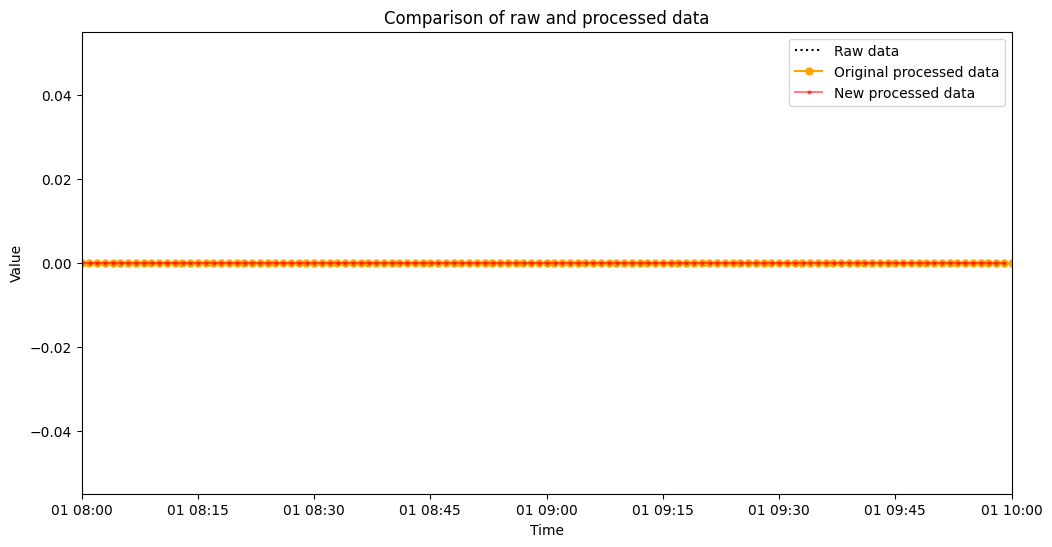

In [250]:
# plot the two series given a time range

def filter_series(data, min_time, max_time):
    # set the time to datetime
    data.index = pd.to_datetime(data.index)
    data = data.sort_index()
    data = data.round(3)
    return data[(data.index >= min_time) & (data.index <= max_time)]


def plot_series(raw_data, original_processed, new_processed, min_time, max_time):
    raw_data = filter_series(raw_data, min_time, max_time)  
    original_processed = filter_series(original_processed, min_time, max_time)
    new_processed = filter_series(new_processed, min_time, max_time)
    plt.figure(figsize=(12, 6))
    plt.plot(raw_data.index, raw_data, label='Raw data', color='black', linestyle='dotted')
    plt.plot(original_processed.index, original_processed, label='Original processed data', color='orange', marker='o', markersize=5)
    plt.plot(new_processed.index, new_processed, label='New processed data', color='red', marker='o', markersize=2, alpha=0.5)
    plt.xlim(min_time, max_time)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Comparison of raw and processed data')
    plt.legend()
    plt.show()

    # # evaluate the difference between the raw data with the other two
    # diff1 = abs(raw_data - original_processed)
    # diff2 = (raw_data - new_processed)
    # print(f"Mean difference between raw data and original processed data: {diff1.mean().values}")
    # print(f"Mean difference between raw data and new processed data: {diff2.mean().values}")

min_time = pd.to_datetime('2020-01-01 08:00:00')
max_time = pd.to_datetime('2020-01-01 10:00:00')
original_processed = complete_series[['time', 'level']].set_index('time')
#original_processed = complete_series[['time', 'depth_s']].set_index('time').rename(columns={'depth_s': sensor})
#original_processed = complete_series[['time', 'raw_value']].set_index('time')
# empty processed data
# regular_data = pd.DataFrame(index=original_processed.index)
# regular_data = pd.DataFrame(index=original_processed.index)
plot_series(raw_data, original_processed, regular_data, min_time, max_time)



In [238]:
filter_series(sensor_data.set_index('time'), min_time, max_time)

,raw_value,value_no_errors,man_remove,ffill,stamp,outbound,frozen,outlier,frozen_high,depth_s,level
time,,,,,,,,,,,
2020-01-01 08:00:00,0.0,0.0,False,False,False,False,False,False,False,0.0,0.0
2020-01-01 08:01:00,0.0,0.0,False,False,False,False,False,False,False,0.0,0.0
2020-01-01 08:02:00,0.0,0.0,False,False,False,False,False,False,False,0.0,0.0
2020-01-01 08:03:00,0.0,0.0,False,False,False,False,False,False,False,0.0,0.0
2020-01-01 08:04:00,0.0,0.0,False,False,False,False,False,False,False,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-01-01 09:56:00,0.0,0.0,False,False,False,False,False,False,False,0.0,0.0
2020-01-01 09:57:00,0.0,0.0,False,False,False,False,False,False,False,0.0,0.0
2020-01-01 09:58:00,0.0,0.0,False,False,False,False,False,False,False,0.0,0.0


Checking the raw again

In [251]:
row = metadata[(metadata['IdMeasurement'] == sensor) & (metadata['Source'] == 'System2000')].iloc[0]

IdMeasurement                                    G71F68Yp1
Area                                              Bellinge
Source                                          System2000
Version                                                 p1
Type                                             Discharge
Folderpath                                   ./2_raw_data/
Filename             data-pG71F68Y-D1-W2-BF1_M5-PV-SMO.txt
TagSRO                         G71F68Y-D1-W2-BF1_M5-PV-SMO
Navn                                             Flowmåler
StartTime                                       01-08-2010
EndTime                                         12-10-2020
Conversion                                          3600.0
comment                                       m3/h -> m3/s
unit                                                  m3/h
obvious_min                                           -5.0
obvious_max                                            5.0
zeropoint                                              N

In [245]:
print(file_path)

/Users/arond.jacobsen/Documents/GitHub/fault_management_uds/data/raw/Bellinge/sensor-data/2_raw_data/SVTP03.G71F68Y-D1-W1-BF1!M5-PV-SMO.F_CV.rpt


In [230]:
row = metadata[(metadata['IdMeasurement'] == sensor) & (metadata['Source'] == 'System2000')].iloc[0]

sensor_data_path = RAW_DATA_DIR / 'Bellinge' / 'sensor-data'
file_path = sensor_data_path / row['Folderpath'] / row['Filename']
conversion = row['Conversion']

data = import_system2000(file_path, conversion)

In [248]:
data.set_index('time', inplace=True)

In [249]:
filter_series(data, min_time, max_time)

,value
time,
2020-01-01 08:00:02,-0.000006
2020-01-01 08:01:03,0.000011
2020-01-01 08:02:02,0.000014
2020-01-01 08:03:02,0.000017
2020-01-01 08:04:03,0.000017
...,...
2020-01-01 09:55:02,0.000019
2020-01-01 09:56:02,0.000017
2020-01-01 09:57:03,0.000017


this is rounded to a 3 decimalas.
- m3/sec
- 0.01 m3/sec is 0.1 m/sec each side. i.e. 10 cm and very little. 
- so this percision loss is ok

In [ ]:

def load_raw_data(metadata, sensor_data_path, save_path):
    """Load raw data files based on metadata."""

    raw_data_paths = {}

    # iterate each sensor group
    n_groups = metadata['IdMeasurement'].nunique()
    i_group = 0
    for sensor_name, sensor_group in metadata.groupby('IdMeasurement'):
        print(f"({i_group+1}/{n_groups}) Loading {sensor_name}")
        # create a dictionary with the sensor id as key and the data as value
        raw_sensor_data = pd.DataFrame()
        # iterate each row in the sensor group
        sensor_group = sensor_group.reset_index(drop=True)
        for i, row in sensor_group.iterrows():
            print(f"    {i+1}/{sensor_group.shape[0]}")
            # get the file path
            file_path = sensor_data_path / row['Folderpath'] / row['Filename']
            # load the raw data file: currently only adjust the datetime column
            sensor_data = load_raw_data_file(file_path, row['Source'], row['Conversion'])
            # sort by time
            sensor_data = sensor_data.sort_values(by='time')
            # add the raw data to the df in the dictionary
            raw_sensor_data = pd.concat([raw_sensor_data, sensor_data])
        # remove duplicated time
        raw_sensor_data = raw_sensor_data.drop_duplicates(subset=['time'])
        # sort by time
        raw_sensor_data = raw_sensor_data.sort_values(by='time')
        # remove nan values
        raw_sensor_data = raw_sensor_data.dropna(subset=['value'])
        # save the raw data as a pickle file
        file_path = save_path / f'{sensor_name}.pkl'
        raw_sensor_data.to_pickle(file_path)
        raw_data_paths[sensor_name] = file_path
        i_group += 1
        print(f"Saved {sensor_name} to {save_path / f'{sensor_name}.pkl'}")
        print('')
    # save the raw data paths
    with open(save_path / 'raw_data_paths.pkl', 'wb') as f:
        pickle.dump(raw_data_paths, f)
    return raw_data_paths


In [ ]:
save_path = INTERIM_DATA_DIR / 'Bellinge' / 'sensor-data'
# create the save path if it does not exist
save_path.mkdir(parents=True, exist_ok=True)

In [ ]:
# RUNTIME: 20 minutes
raw_data_paths = load_raw_data(metadata, sensor_data_path, save_path)

Saved G71F04R_Level1 to /Users/arond.jacobsen/Documents/GitHub/fault_management_uds/data/interim/Bellinge/sensor-data/G71F04R_Level1.pkl

Saved G71F04R_Level2 to /Users/arond.jacobsen/Documents/GitHub/fault_management_uds/data/interim/Bellinge/sensor-data/G71F04R_Level2.pkl

Saved G71F05R_LevelBasin to /Users/arond.jacobsen/Documents/GitHub/fault_management_uds/data/interim/Bellinge/sensor-data/G71F05R_LevelBasin.pkl

Saved G71F05R_LevelInlet to /Users/arond.jacobsen/Documents/GitHub/fault_management_uds/data/interim/Bellinge/sensor-data/G71F05R_LevelInlet.pkl

Saved G71F05R_position to /Users/arond.jacobsen/Documents/GitHub/fault_management_uds/data/interim/Bellinge/sensor-data/G71F05R_position.pkl

Saved G71F06R_LevelInlet to /Users/arond.jacobsen/Documents/GitHub/fault_management_uds/data/interim/Bellinge/sensor-data/G71F06R_LevelInlet.pkl

Saved G71F68Y_LevelPS to /Users/arond.jacobsen/Documents/GitHub/fault_management_uds/data/interim/Bellinge/sensor-data/G71F68Y_LevelPS.pkl

Save

In [ ]:
# load the raw data paths
with open(save_path / 'raw_data_paths.pkl', 'rb') as f:
    raw_data_paths = pickle.load(f)

## Pre-processing the sensor data

The goal is to:
- preprocess the raw data based on the provided scripts
- this will clean the data in a minimal way

In [ ]:

def preprocess_raw_data(metadata):
    """Preprocess the raw data files."""

    if metadata.at[i,'Source'] == 'iFix': 
        # fill the data with the previous value if it is observed after the 1 minute interval
        data = Fill_data_savings_points(raw_data) 
        # stamp the data the iFix error code is 0
        stamp_id = Stamped_error(data.value, data.quality_ifix, 0) #0 is error in data
    else:
        # no ffill on the other sources
        data = NoFill_data_savings_points(raw_data)
        stamp_id = pd.Series(np.zeros(len(data)),dtype=bool)
    print("Stamp_id and padding of datasaving values is calculated")

    # remove the manual removals
    man_remove_id = Remove_man(data, man_remove, name)
    
    # check if the data is out of bounds
    outbound_id = Out_of_bounds(data.value, metadata.at[i,'obvious_min'], metadata.at[i,'obvious_max'])
    print("Outbound_id is calculated")
    
    # excluded the frozen data
    if name == 'G71F68Y_LevelPS' or metadata.at[i,'Type'] == 'Position':
        frozen_id2 = pd.Series(np.zeros(len(data.value)),dtype=bool)    
    else: 
        frozen_id2 = Frozen_sensor(data.value, data.time, 0, metadata.at[i,'window_frozen'])
    print("Frozen_id is calculated")
    
   
    if metadata.at[i,'Source'] == 'Danova': 
        outlier_id = Outlier_point(data.value, metadata.at[i,'outlier_threshold'], metadata.at[i,'outlier_width'])
    else: 
        outlier_id = pd.Series(np.zeros(len(data.value)),dtype=bool)
    print("Outlier_id is calculated")

    
    value_no_errors = data.value.copy()
    value_no_errors[stamp_id | outbound_id | frozen_id2 | man_remove_id | outlier_id] = np.nan  

    # make list with errors instead with numbers
    data_with_tags = pd.DataFrame({'time': data.loc[:,'time'],
                              'raw_value': data.loc[:,'value'],
                              'value_no_errors': value_no_errors,
                              'man_remove': man_remove_id,
                              'ffill': data.loc[:,'ffill'],
                              'stamp': stamp_id,
                              'outbound': outbound_id,
                              'frozen': frozen_id2,
                              'outlier': outlier_id})
        
    # save the preprocessed data as a pickle file
    return data_with_tags

def preprocess_raw_data(raw_data_paths, save_path):
    pass

